In [3]:
import os
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# 작업 디렉토리 변경
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

Mounted at /content/drive


In [2]:
import numpy as np
import json
import pandas as pd

def convert_json_to_csv(json_file_path, output_csv_path):

    # JSON 파일 로드
    with open(json_file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    # DataFrame 변환
    df = pd.DataFrame(data)

    # 상담 텍스트(HS01, HS02, HS03만 합침) 추출
    df["text"] = df["talk"].apply(lambda x: " ".join([x["content"].get(k, "") for k in ["HS01", "HS02", "HS03"]]).strip())
    df["emotion"] = df["profile"].apply(lambda x: x["emotion"]["type"])  # 감정 (E10~E69)

    # 필요 없는 컬럼 제거
    df = df[["text", "emotion"]]

    # CSV 저장
    df.to_csv(output_csv_path, index=False, encoding="utf-8-sig")
    print(f"✅ 변환 완료: {output_csv_path}")


# 🔹 두 개의 JSON 파일 변환 실행
convert_json_to_csv("data/감성대화말뭉치(최종데이터)_Training.json", "data/250317_train_dataset.csv")
convert_json_to_csv("data/감성대화말뭉치(최종데이터)_Validation.json", "data/250317_test_dataset.csv")


✅ 변환 완료: data/250317_train_dataset.csv
✅ 변환 완료: data/250317_test_dataset.csv


In [4]:
train_df = pd.read_csv('data/250317_train_dataset.csv', encoding='utf-8-sig') # utf-8-sig??
test_df = pd.read_csv('data/250317_test_dataset.csv', encoding='utf-8-sig')

In [6]:
print(train_df.head())
print(test_df.head())

                                                text emotion
0  일은 왜 해도 해도 끝이 없을까? 화가 난다. 그냥 내가 해결하는 게 나아. 남들한...     E18
1  이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....     E18
2  회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...     E18
3  직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...     E18
4  얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나. 상사인 나에게 ...     E18
                                                text emotion
0  이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...     E31
1  회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워. 나에게 너무 크...     E31
2  상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워. 무섭게 생겼는데도 업무를 보려...     E31
3  이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다. 첫 직장...     E31
4  직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼. 내가 낯가림이 심해서 친해질 수...     E31


In [8]:
import re

def clean_text(text):
    text = re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text)  # 한글, 영어, 숫자, 공백만 유지
    text = re.sub(r"\s+", " ", text).strip()  # 중복 공백 제거
    return text

train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)


In [10]:
!pip install konlpy


In [12]:
from konlpy.tag import Okt
from tqdm import tqdm

# ✅ 형태소 분석기 초기화
okt = Okt()
tqdm.pandas()  # 진행 상황 표시

# ✅ 형태소 분석 및 불용어 제거 함수
def preprocess_text_with_okt(text):
    if not isinstance(text, str):  # NaN 값 처리
        return ""

    parsed_text = okt.pos(text)  # 형태소 분석

    keywords = []
    for word, tag in parsed_text:
        if tag in ["Noun", "Adjective", "Verb"]:  # 명사, 형용사, 동사만 유지
            keywords.append(word)

    return " ".join(keywords)  # 공백으로 연결하여 반환

# ✅ 형태소 분석 적용
train_df["text"] = train_df["text"].progress_apply(preprocess_text_with_okt)
test_df["text"] = test_df["text"].progress_apply(preprocess_text_with_okt)

print("✅ 형태소 분석 및 불용어 제거 완료!")


100%|█████████████████████████████████████████████████████████████████████████████| 6640/6640 [00:14<00:00, 466.65it/s]

✅ 형태소 분석 및 불용어 제거 완료!


In [13]:
from sklearn.preprocessing import LabelEncoder

# ✅ 감정 라벨 인코더 초기화
emotion_encoder = LabelEncoder()

# ✅ 감정(`emotion`)을 숫자로 변환
train_df["emotion"] = emotion_encoder.fit_transform(train_df["emotion"])
test_df["emotion"] = emotion_encoder.transform(test_df["emotion"])

# ✅ 변환된 감정 라벨 개수 확인
print("✅ 감정 라벨 개수:", len(emotion_encoder.classes_))  # 60개여야 정상

# ✅ 변환된 데이터 확인
print(train_df.head())
print(test_df.head())


✅ 감정 라벨 개수: 60
                                                text  emotion
0  일 왜 해도 해도 끝 없을까 화가 난다 그냥 내 해결 하는 게 남 부담 주고 싶지도 않고        8
1  이번 달 또 급여 깎였어 물가 오르는데 월급 자꾸 깎이니까 화가 나 최대한 지출 억...        8
2  회사 신입 들어왔는데 말투 거슬려 그런 애 매일 봐야 한다고 생각 하니까 스트레스 ...        8
3  직장 막내 이유 나 온갖 심부름 시켜 일도 많은 데 정말 분하고 섭섭해 직장 사람 ...        8
4  얼마 전 입사 신입사원 나를 무시 하는 것 같아서 화가 나 상사 나 먼저 인사 하지...        8
                                                text  emotion
0  이번 프로젝트 발표 하는데 내 실수 하는 바람 우리 팀 감점 받았어 미안해 내 능력...       21
1  회사 중요한 프로젝트 혼자 하게 됐는데 솔직히 두렵고 무서워 나 크게 느껴지는 중요...       21
2  상사 무섭게 생겨서 친해지는 게 두려워 무섭게 생겼는데도 업무 보려면 친해져야 할 ...       21
3  이번 힘들게 들어간 첫 직장 거든 첫 직장 그런지 긴장 된다 첫 직장 잘 적응 할 ...       21
4  직장 동료 관계 안 좋아질까 봐 걱정 돼 내 낯가림 심해서 친해질 수 있을지 모르겠...       21


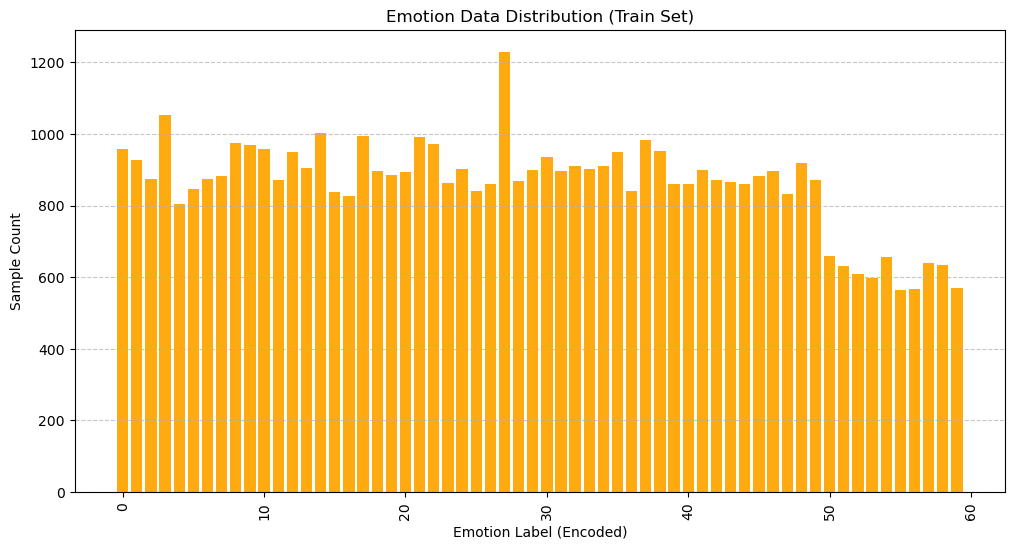

In [14]:
import matplotlib.pyplot as plt

# 감정 데이터 개수 확인
emotion_counts = train_df["emotion"].value_counts().sort_index()

# 감정 데이터 분포 시각화 (plt 사용)
plt.figure(figsize=(12, 6))
plt.bar(emotion_counts.index, emotion_counts.values, color='#fa1')
plt.xlabel("Emotion Label (Encoded)")
plt.ylabel("Sample Count")
plt.title("Emotion Data Distribution (Train Set)")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 가독성을 위한 그리드 추가
plt.show()


In [15]:
# ✅ 전처리된 데이터 저장
train_df.to_csv("data/250317_train_emotion.csv", index=False, encoding="utf-8-sig")
test_df.to_csv("data/250317_test_emotion.csv", index=False, encoding="utf-8-sig")

print("✅ 전처리된 데이터 저장 완료!")


✅ 전처리된 데이터 저장 완료!


In [18]:
from transformers import BertModel
import torch
import torch.nn as nn

class KoBERTEmotion(nn.Module):
    def __init__(self, model_name, num_emotions, dropout_prob=0.1):
        super(KoBERTEmotion, self).__init__()

        # KoBERT 모델 로드
        self.bert = BertModel.from_pretrained(model_name)

        # 드롭아웃 적용
        self.dropout = nn.Dropout(dropout_prob)

        # 감정 분류를 위한 Fully Connected Layer
        self.fc = nn.Linear(768, 256)  # BERT의 출력 크기(768) → 256차원
        self.relu = nn.ReLU()

        # 최종 감정 예측 레이어
        self.emotion_classifier = nn.Linear(256, num_emotions)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # BERT 모델 Forward
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # CLS 토큰의 hidden state 활용 (batch_size, 768)
        cls_output = outputs.last_hidden_state[:, 0, :]

        # FC Layer 적용 (ReLU + Dropout)
        x = self.fc(cls_output)
        x = self.relu(x)
        x = self.dropout(x)

        # 감정 예측
        emotion_logits = self.emotion_classifier(x)

        return emotion_logits


In [4]:
import pandas as pd
train_df = pd.read_csv("data/250317_train_emotion.csv", encoding="utf-8-sig")
test_df = pd.read_csv("data/250317_test_emotion.csv",  encoding="utf-8-sig")

print("✅ 데이터 로드 완료!")
print(train_df.head())  # 데이터 샘플 확인

✅ 데이터 로드 완료!
                                                text  emotion
0  일 왜 해도 해도 끝 없을까 화가 난다 그냥 내 해결 하는 게 남 부담 주고 싶지도 않고        8
1  이번 달 또 급여 깎였어 물가 오르는데 월급 자꾸 깎이니까 화가 나 최대한 지출 억...        8
2  회사 신입 들어왔는데 말투 거슬려 그런 애 매일 봐야 한다고 생각 하니까 스트레스 ...        8
3  직장 막내 이유 나 온갖 심부름 시켜 일도 많은 데 정말 분하고 섭섭해 직장 사람 ...        8
4  얼마 전 입사 신입사원 나를 무시 하는 것 같아서 화가 나 상사 나 먼저 인사 하지...        8


In [6]:
from transformers import AutoTokenizer

# ✅ KoBERT 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)

print("✅ KoBERT 토크나이저 로드 완료!")


✅ KoBERT 토크나이저 로드 완료!


In [8]:
import torch
from torch.utils.data import Dataset

# ✅ 감정 분류 데이터셋 정의
class EmotionDataset(Dataset):
    def __init__(self, texts, emotions, tokenizer, max_length=128):
        self.texts = texts
        self.emotions = list(map(int, emotions))  # 🔹 문자열 → 정수 변환
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        token_type_ids = encoding["token_type_ids"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
            "emotion": torch.tensor(self.emotions[idx], dtype=torch.long),  # ✅ 변환된 정수형 사용
        }


print("✅ PyTorch Dataset 정의 완료!")


✅ PyTorch Dataset 정의 완료!


In [10]:
import pandas as pd

# ✅ 전처리된 감정 데이터 로드
train_df = pd.read_csv("data/250317_train_emotion.csv", encoding="utf-8-sig")
test_df = pd.read_csv("data/250317_test_emotion.csv", encoding="utf-8-sig")

# ✅ Dataset 생성
train_dataset = EmotionDataset(
    train_df["text"].tolist(),
    train_df["emotion"].tolist(),
    tokenizer
)

test_dataset = EmotionDataset(
    test_df["text"].tolist(),
    test_df["emotion"].tolist(),
    tokenizer
)

print("✅ Dataset 생성 완료!")


✅ Dataset 생성 완료!


In [12]:
from torch.utils.data import DataLoader

# ✅ DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("✅ DataLoader 생성 완료!")


✅ DataLoader 생성 완료!


In [14]:
import torch

# ✅ GPU 사용 가능하면 GPU로 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Using device: {device}")


✅ Using device: cuda


In [28]:
# ✅ KoBERT 감정 분류 모델 불러오기
num_emotions = len(train_df["emotion"].unique())  # 감정 개수 (60개)

model = KoBERTEmotion(
    model_name="monologg/kobert",
    num_emotions=num_emotions,
    dropout_prob=0.1
).to(device)

print("✅ KoBERT 모델 초기화 완료!")


✅ KoBERT 모델 초기화 완료!


In [30]:
from torch.optim import AdamW
import torch.nn as nn

# ✅ 손실 함수 (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# ✅ 옵티마이저 (AdamW)
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

print("✅ 손실 함수 및 옵티마이저 설정 완료!")


✅ 손실 함수 및 옵티마이저 설정 완료!


In [32]:
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import torch

# ✅ 학습 관련 변수 초기화
num_epochs = 30
best_loss = float("inf")
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

# ✅ Early Stopping 설정
early_stopping_patience = 3
no_improve_count = 0

for epoch in range(num_epochs):
    start_time = time.time()
    print(f"\n🔥 Epoch {epoch + 1}/{num_epochs}")

    # 🔹 Training 단계
    model.train()
    train_loss = 0
    correct_emotions, total_samples = 0, 0

    train_iterator = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", dynamic_ncols=True)

    for batch in train_iterator:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["emotion"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, token_type_ids)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 정확도 계산
        preds = torch.argmax(logits, dim=1)
        correct_emotions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

        # 🔹 tqdm 한 줄 갱신 (값 형식 오류 수정)
        train_iterator.set_postfix({
            "Loss": f"{train_loss / (total_samples + 1e-8):.4f}",
            "Accuracy": f"{correct_emotions / (total_samples + 1e-8):.4f}"
        })

    # 🔹 학습 손실 및 정확도 기록
    train_loss /= len(train_loader)
    train_acc = correct_emotions / total_samples
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)

    # 🔹 Validation 단계
    model.eval()
    val_loss = 0
    correct_emotions, total_samples = 0, 0

    val_iterator = tqdm(test_loader, desc=f"Validating Epoch {epoch + 1}", dynamic_ncols=True)

    with torch.no_grad():
        for batch in val_iterator:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            labels = batch["emotion"].to(device)

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            # 정확도 계산
            preds = torch.argmax(logits, dim=1)
            correct_emotions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

            # 🔹 tqdm 한 줄 갱신 (값 형식 오류 수정)
            val_iterator.set_postfix({
                "Loss": f"{val_loss / (total_samples + 1e-8):.4f}",
                "Accuracy": f"{correct_emotions / (total_samples + 1e-8):.4f}"
            })

    # 🔹 검증 손실 및 정확도 기록
    val_loss /= len(test_loader)
    val_acc = correct_emotions / total_samples
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    elapsed_time = time.time() - start_time

    print(f"📉 Epoch {epoch + 1}/{num_epochs} - Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | Time: {elapsed_time:.2f} sec")

    # 🔹 베스트 모델 저장
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), "checkpoints/250317-AI-004-best_model.pth")
        torch.save(history, "checkpoints/250317-AI-004-history.pth")
        print("✅ Best model & history saved!")
    else:
        no_improve_count += 1

    # 🔹 Early Stopping 체크
    if no_improve_count >= early_stopping_patience:
        print("⏹️ Early Stopping Triggered! Training Stopped.")
        break

# 🔹 최종 모델 저장
torch.save(model.state_dict(), "250317-AI-004-final_model.pth")
torch.save(history, "final_history.pth")
print("🎉 Training completed! Final model & history saved.")



🔥 Epoch 1/30


Validating Epoch 1: 100%|██████████████████████████████| 830/830 [00:40<00:00, 20.57it/s, Loss=0.3641, Accuracy=0.3498]


📉 Epoch 1/30 - Loss: 2.9129 | Accuracy: 0.3498 | Time: 1147.58 sec
✅ Best model & history saved!

🔥 Epoch 2/30


Validating Epoch 2: 100%|██████████████████████████████| 830/830 [00:40<00:00, 20.47it/s, Loss=0.3091, Accuracy=0.4014]


📉 Epoch 2/30 - Loss: 2.4732 | Accuracy: 0.4014 | Time: 1146.11 sec
✅ Best model & history saved!

🔥 Epoch 3/30


Validating Epoch 3: 100%|██████████████████████████████| 830/830 [00:41<00:00, 20.13it/s, Loss=0.2833, Accuracy=0.4381]


📉 Epoch 3/30 - Loss: 2.2667 | Accuracy: 0.4381 | Time: 1147.36 sec
✅ Best model & history saved!

🔥 Epoch 4/30


Validating Epoch 4: 100%|██████████████████████████████| 830/830 [00:40<00:00, 20.51it/s, Loss=0.2732, Accuracy=0.4483]


📉 Epoch 4/30 - Loss: 2.1859 | Accuracy: 0.4483 | Time: 1141.93 sec
✅ Best model & history saved!

🔥 Epoch 5/30


Validating Epoch 5: 100%|██████████████████████████████| 830/830 [00:41<00:00, 20.07it/s, Loss=0.2585, Accuracy=0.4711]


📉 Epoch 5/30 - Loss: 2.0681 | Accuracy: 0.4711 | Time: 1303.67 sec
✅ Best model & history saved!

🔥 Epoch 6/30


Validating Epoch 6: 100%|██████████████████████████████| 830/830 [00:42<00:00, 19.54it/s, Loss=0.2545, Accuracy=0.4965]


📉 Epoch 6/30 - Loss: 2.0356 | Accuracy: 0.4965 | Time: 1153.73 sec
✅ Best model & history saved!

🔥 Epoch 7/30


Validating Epoch 7: 100%|██████████████████████████████| 830/830 [00:40<00:00, 20.51it/s, Loss=0.2561, Accuracy=0.5014]


📉 Epoch 7/30 - Loss: 2.0488 | Accuracy: 0.5014 | Time: 1163.55 sec

🔥 Epoch 8/30


Validating Epoch 8: 100%|██████████████████████████████| 830/830 [00:40<00:00, 20.63it/s, Loss=0.2530, Accuracy=0.5123]


📉 Epoch 8/30 - Loss: 2.0237 | Accuracy: 0.5123 | Time: 1137.17 sec
✅ Best model & history saved!

🔥 Epoch 9/30


Validating Epoch 9: 100%|██████████████████████████████| 830/830 [00:39<00:00, 20.97it/s, Loss=0.2502, Accuracy=0.5367]


📉 Epoch 9/30 - Loss: 2.0014 | Accuracy: 0.5367 | Time: 1138.38 sec
✅ Best model & history saved!

🔥 Epoch 10/30


Validating Epoch 10: 100%|█████████████████████████████| 830/830 [01:20<00:00, 10.34it/s, Loss=0.2562, Accuracy=0.5456]


📉 Epoch 10/30 - Loss: 2.0495 | Accuracy: 0.5456 | Time: 1236.37 sec

🔥 Epoch 11/30


Validating Epoch 11: 100%|█████████████████████████████| 830/830 [00:40<00:00, 20.25it/s, Loss=0.2566, Accuracy=0.5560]


📉 Epoch 11/30 - Loss: 2.0525 | Accuracy: 0.5560 | Time: 1319.92 sec

🔥 Epoch 12/30


Validating Epoch 12: 100%|█████████████████████████████| 830/830 [00:39<00:00, 21.06it/s, Loss=0.2608, Accuracy=0.5633]


📉 Epoch 12/30 - Loss: 2.0868 | Accuracy: 0.5633 | Time: 1138.23 sec
⏹️ Early Stopping Triggered! Training Stopped.
🎉 Training completed! Final model & history saved.


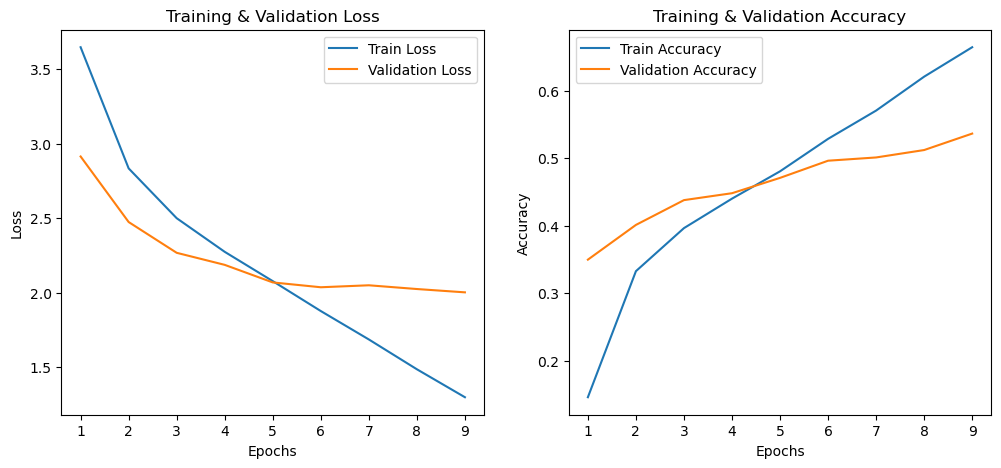

In [34]:
import torch
import matplotlib.pyplot as plt

# ✅ 저장된 학습 기록 로드
history_path = "checkpoints/250317-AI-004-history.pth"
history = torch.load(history_path)

# ✅ Loss & Accuracy 시각화
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# 🔹 Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# 🔹 Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [36]:
from sklearn.metrics import accuracy_score, f1_score
import torch

# ✅ 베스트 모델 로드
best_model_path = "checkpoints/250317-AI-004-best_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# ✅ 테스트 데이터 평가
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["emotion"].to(device)

        logits = model(input_ids, attention_mask, token_type_ids)
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# ✅ EM(Exact Match) & F1 Score 계산
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="macro") 


print(f"✅ Test Accuracy: {accuracy:.4f}")
print(f"✅ Test F1-Score: {f1:.4f}")


✅ Test Accuracy: 0.5367
✅ Test F1-Score: 0.5261
